In [7]:
import tensorflow as tf
import math
print("TensorFlow version:", tf.__version__)
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, BatchNormalization,Input,ReLU, Add, AveragePooling2D,MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory

TensorFlow version: 2.9.2


In [8]:
def resnet_block(x, filters, kernel_size, strides):
    # Shortcut path
    shortcut = x
    if strides != 1 or x.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=strides)(x)
        shortcut = BatchNormalization()(shortcut)
    
    # Residual path
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Residual connection
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x


In [9]:
def build_resnet18(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Conv1 layer
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # Conv2 layer
    x = resnet_block(x, filters=64, kernel_size=3, strides=1)
    x = resnet_block(x, filters=64, kernel_size=3, strides=1)
    
    # Conv3 layer
    x = resnet_block(x, filters=128, kernel_size=3, strides=2)
    x = resnet_block(x, filters=128, kernel_size=3, strides=1)
    
    # Conv4 layer
    x = resnet_block(x, filters=256, kernel_size=3, strides=2)
    x = resnet_block(x, filters=256, kernel_size=3, strides=1)
    
    # Conv5 layer
    x = resnet_block(x, filters=512, kernel_size=3, strides=2)
    x = resnet_block(x, filters=512, kernel_size=3, strides=1)
    
    # Average pooling layer
    x = AveragePooling2D(pool_size=7)(x)
    
    # Output layer
    x = Flatten()(x)
    outputs = Dense(1, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model
resnet18_model=build_resnet18(input_shape=(227,227,1))

In [10]:
train_dir="/notebooks/ultrasound/train"
validation_dir=train_dir
test_dir="/notebooks/ultrasound/val"
batch_size=64
test_train_split=0.3
train_data = image_dataset_from_directory(\
      train_dir,color_mode="grayscale",image_size=(227,227) ,\
      subset='training',seed=5, validation_split=test_train_split,\
      batch_size=batch_size)
validation_data = image_dataset_from_directory(validation_dir,
      color_mode="grayscale",image_size=(227,227), subset='validation',seed=5,\
      validation_split=test_train_split,batch_size=batch_size)
test_data = image_dataset_from_directory(test_dir,
      color_mode="grayscale",image_size=(227,227), batch_size=batch_size)

Found 8116 files belonging to 2 classes.
Using 5682 files for training.
Found 8116 files belonging to 2 classes.
Using 2434 files for validation.
Found 900 files belonging to 2 classes.


In [11]:
resnet18_model.compile(loss="BinaryCrossentropy", optimizer='Adam', metrics=["BinaryAccuracy"])

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [13]:
history = resnet18_model.fit(train_data,
            epochs=100,
            validation_data=validation_data,callbacks=[callback])

Epoch 1/100
89/89 [==============================] - 16s 119ms/step - loss: 0.6673 - binary_accuracy: 0.4995 - val_loss: 135.0847 - val_binary_accuracy: 0.4947
Epoch 2/100
89/89 [==============================] - 10s 109ms/step - loss: 0.4134 - binary_accuracy: 0.4995 - val_loss: 52.1229 - val_binary_accuracy: 0.4947
Epoch 3/100
89/89 [==============================] - 10s 109ms/step - loss: 0.3351 - binary_accuracy: 0.4995 - val_loss: 16.8099 - val_binary_accuracy: 0.4947
Epoch 4/100
89/89 [==============================] - 10s 110ms/step - loss: 0.2422 - binary_accuracy: 0.4995 - val_loss: 0.9189 - val_binary_accuracy: 0.4947
Epoch 5/100
89/89 [==============================] - 10s 110ms/step - loss: 0.1958 - binary_accuracy: 0.4995 - val_loss: 1.7266 - val_binary_accuracy: 0.4947
Epoch 6/100
89/89 [==============================] - 10s 110ms/step - loss: 0.1447 - binary_accuracy: 0.4995 - val_loss: 1.4326 - val_binary_accuracy: 0.4947
Epoch 7/100
89/89 [=============================

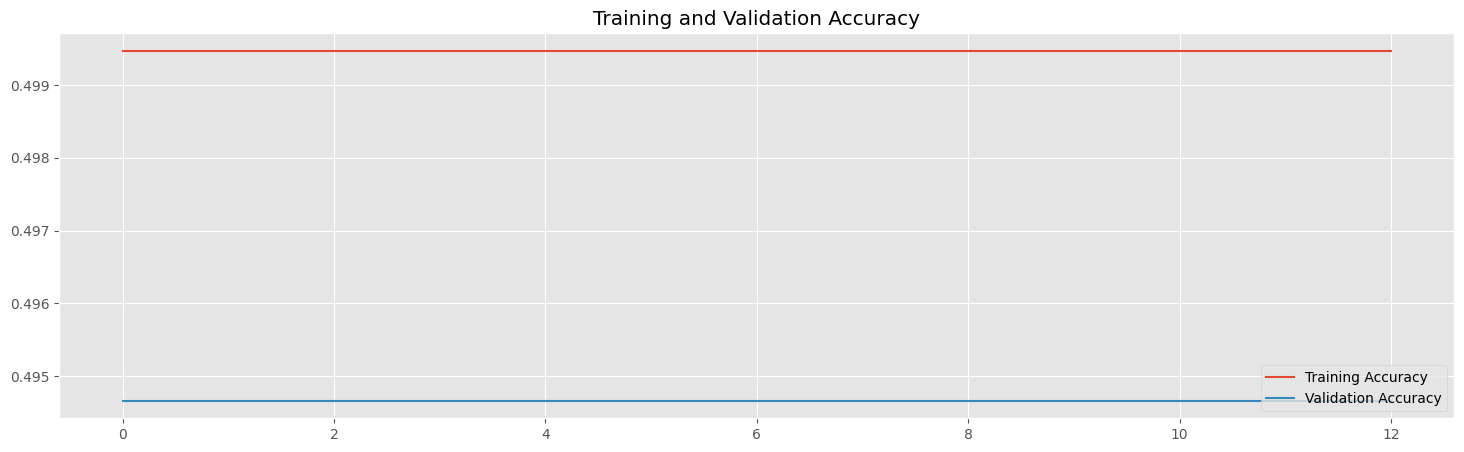

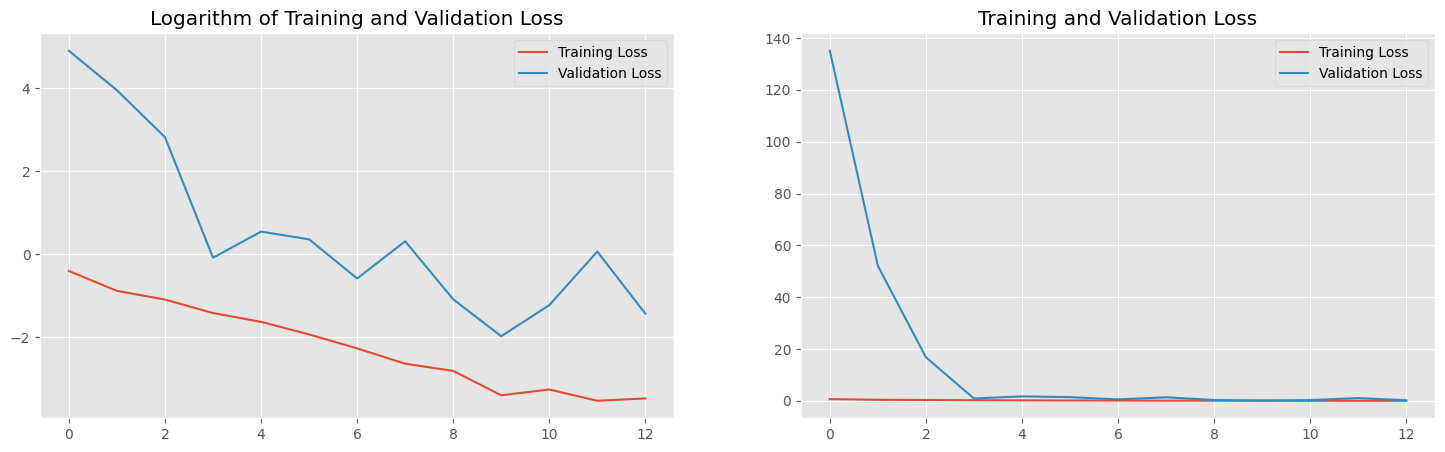

In [14]:
epochs_run=len(history.epoch)
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs_run)
plt.style.use('ggplot')
plt.figure(figsize=(18, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(18, 5))
plt.subplot(1,2,1)
plt.plot(epochs_range, np.log(loss), label='Training Loss')
plt.plot(epochs_range, np.log(val_loss), label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Logarithm of Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

plt.show()

In [15]:
results = resnet18_model.evaluate(test_data, batch_size=128)
print("test loss, test acc:", results)

15/15 [==============================] - 1s 37ms/step - loss: 0.5070 - binary_accuracy: 0.4444
test loss, test acc: [0.5069856643676758, 0.4444444477558136]


In [16]:
# resnet18_model.save('../models/fcn_0_ultrasound')